In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from torchvision.transforms import Lambda

# Define AlexNet adapted for CIFAR-10/CIFAR-100
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# PCA Color Augmentation
def pca_color_augmentation(image):
    reshaped_image = image.reshape(-1, 3).astype(np.float32)
    mean = np.mean(reshaped_image, axis=0)
    std = np.std(reshaped_image, axis=0)

    # Avoid division by zero
    std[std == 0] = 1

    normalized_image = (reshaped_image - mean) / std

    cov_matrix = np.cov(normalized_image, rowvar=False)

    # Add a small value to the diagonal for numerical stability
    cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-5

    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]
    eigenvalues = eigenvalues[sorted_indices]

    alphas = np.random.normal(0, 0.1, 3)
    pca_jitter = np.dot(eigenvectors, alphas * eigenvalues)
    pca_jitter = (pca_jitter * std + mean).astype(np.float32)
    augmented_image = normalized_image + pca_jitter
    augmented_image = (augmented_image * std + mean).astype(np.uint8)

    return augmented_image.reshape(image.shape)


# Transforms including PCA color augmentation
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    Lambda(lambda x: torch.tensor(pca_color_augmentation(x.numpy().transpose((1, 2, 0))), dtype=torch.float32).permute(2, 0, 1)),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 or CIFAR-100
def get_dataloaders(dataset='CIFAR10', batch_size=128):
    if dataset == 'CIFAR10':
        train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
        test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)
        num_classes = 10
    elif dataset == 'CIFAR100':
        train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transforms)
        test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transforms)
        num_classes = 100

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, test_loader, num_classes

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=25, device='cuda'):
    model.to(device)
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)

        val_acc = val_running_corrects.double() / len(test_loader.dataset)
        print(f'Epoch {epoch}/{num_epochs-1}, Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}')

        # Step the scheduler
        scheduler.step(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    return model

# Define dataset and dataloaders
train_loader, test_loader, num_classes = get_dataloaders(dataset='CIFAR10', batch_size=128)

# Initialize model, loss function, optimizer, and scheduler
model = AlexNet(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10, verbose=True, eps=1e-8)

# Train the model
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=50)


Files already downloaded and verified
Files already downloaded and verified
Epoch 0/49, Loss: 2.3020, Train Acc: 0.1013, Val Acc: 0.1241
Epoch 1/49, Loss: 2.2509, Train Acc: 0.1383, Val Acc: 0.2469
Epoch 2/49, Loss: 2.2017, Train Acc: 0.1648, Val Acc: 0.2653
Epoch 3/49, Loss: 2.1680, Train Acc: 0.1700, Val Acc: 0.2515
Epoch 4/49, Loss: 2.1465, Train Acc: 0.1792, Val Acc: 0.2807
Epoch 5/49, Loss: 2.1225, Train Acc: 0.1920, Val Acc: 0.2997
Epoch 6/49, Loss: 2.1065, Train Acc: 0.1972, Val Acc: 0.3308
Epoch 7/49, Loss: 2.1001, Train Acc: 0.2006, Val Acc: 0.3030
Epoch 8/49, Loss: 2.0918, Train Acc: 0.2085, Val Acc: 0.2819
Epoch 9/49, Loss: 2.0788, Train Acc: 0.2132, Val Acc: 0.2734
Epoch 10/49, Loss: 2.0729, Train Acc: 0.2141, Val Acc: 0.3012
Epoch 11/49, Loss: 2.0591, Train Acc: 0.2226, Val Acc: 0.3389
Epoch 12/49, Loss: 2.0465, Train Acc: 0.2241, Val Acc: 0.3690
Epoch 13/49, Loss: 2.0427, Train Acc: 0.2275, Val Acc: 0.3542
Epoch 14/49, Loss: 2.0382, Train Acc: 0.2277, Val Acc: 0.3446
Epoc

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from torchvision.transforms import Lambda

# Define AlexNet adapted for CIFAR-10/CIFAR-100
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# PCA Color Augmentation
def pca_color_augmentation(image):
    reshaped_image = image.reshape(-1, 3).astype(np.float32)
    mean = np.mean(reshaped_image, axis=0)
    std = np.std(reshaped_image, axis=0)

    # Avoid division by zero
    std[std == 0] = 1

    normalized_image = (reshaped_image - mean) / std

    cov_matrix = np.cov(normalized_image, rowvar=False)

    # Add a small value to the diagonal for numerical stability
    cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-5

    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]
    eigenvalues = eigenvalues[sorted_indices]

    alphas = np.random.normal(0, 0.1, 3)
    pca_jitter = np.dot(eigenvectors, alphas * eigenvalues)
    pca_jitter = (pca_jitter * std + mean).astype(np.float32)
    augmented_image = normalized_image + pca_jitter
    augmented_image = (augmented_image * std + mean).astype(np.uint8)

    return augmented_image.reshape(image.shape)


# Transforms including PCA color augmentation
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4), #40x40 pixels before the crop.
    transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    Lambda(lambda x: torch.tensor(pca_color_augmentation(x.numpy().transpose((1, 2, 0))), dtype=torch.float32).permute(2, 0, 1)),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 or CIFAR-100
def get_dataloaders(dataset='CIFAR10', batch_size=128):
    if dataset == 'CIFAR10':
        train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
        test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)
        num_classes = 10
    elif dataset == 'CIFAR100':
        train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transforms)
        test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transforms)
        num_classes = 100

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, test_loader, num_classes

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=25, device='cuda'):
    model.to(device)
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)

        val_acc = val_running_corrects.double() / len(test_loader.dataset)
        print(f'Epoch {epoch}/{num_epochs-1}, Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}')

        # Step the scheduler
        scheduler.step(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    return model

# Define dataset and dataloaders
train_loader, test_loader, num_classes = get_dataloaders(dataset='CIFAR10', batch_size=128)

# Initialize model, loss function, optimizer, and scheduler
model = AlexNet(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10, verbose=True, eps=1e-8)

# Train the model
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=100)


Files already downloaded and verified
Files already downloaded and verified
Epoch 0/99, Loss: 2.3016, Train Acc: 0.1043, Val Acc: 0.1086
Epoch 1/99, Loss: 2.2461, Train Acc: 0.1433, Val Acc: 0.2405
Epoch 2/99, Loss: 2.2090, Train Acc: 0.1626, Val Acc: 0.2754
Epoch 3/99, Loss: 2.1720, Train Acc: 0.1708, Val Acc: 0.2842
Epoch 4/99, Loss: 2.1483, Train Acc: 0.1802, Val Acc: 0.2679
Epoch 5/99, Loss: 2.1261, Train Acc: 0.1902, Val Acc: 0.2903
Epoch 6/99, Loss: 2.1074, Train Acc: 0.1997, Val Acc: 0.3355
Epoch 7/99, Loss: 2.0979, Train Acc: 0.1992, Val Acc: 0.2601
Epoch 8/99, Loss: 2.0824, Train Acc: 0.2104, Val Acc: 0.3071
Epoch 9/99, Loss: 2.0802, Train Acc: 0.2103, Val Acc: 0.3357
Epoch 10/99, Loss: 2.0730, Train Acc: 0.2128, Val Acc: 0.3113
Epoch 11/99, Loss: 2.0594, Train Acc: 0.2221, Val Acc: 0.3295
Epoch 12/99, Loss: 2.0529, Train Acc: 0.2247, Val Acc: 0.3317
Epoch 13/99, Loss: 2.0415, Train Acc: 0.2273, Val Acc: 0.4017
Epoch 14/99, Loss: 2.0376, Train Acc: 0.2273, Val Acc: 0.3661
Epoc

THIS CODE with PCA!!!!!!!!

Files already downloaded and verified
Files already downloaded and verified
Epoch 0/199, Loss: 2.1717, Train Acc: 0.1816, Val Acc: 0.2303
Epoch 1/199, Loss: 2.0734, Train Acc: 0.2304, Val Acc: 0.2533
Epoch 2/199, Loss: 2.0337, Train Acc: 0.2452, Val Acc: 0.3066
Epoch 3/199, Loss: 2.0061, Train Acc: 0.2604, Val Acc: 0.2737
Epoch 4/199, Loss: 1.9886, Train Acc: 0.2680, Val Acc: 0.3126
Epoch 5/199, Loss: 1.9701, Train Acc: 0.2766, Val Acc: 0.3234
Epoch 6/199, Loss: 1.9514, Train Acc: 0.2856, Val Acc: 0.2916
Epoch 7/199, Loss: 1.9374, Train Acc: 0.2898, Val Acc: 0.3341
Epoch 8/199, Loss: 1.9244, Train Acc: 0.2971, Val Acc: 0.2929
Epoch 9/199, Loss: 1.9140, Train Acc: 0.2995, Val Acc: 0.4025
Epoch 10/199, Loss: 1.9022, Train Acc: 0.3033, Val Acc: 0.3387
Epoch 11/199, Loss: 1.8913, Train Acc: 0.3103, Val Acc: 0.3114
Epoch 12/199, Loss: 1.8822, Train Acc: 0.3132, Val Acc: 0.3612
Epoch 13/199, Loss: 1.8718, Train Acc: 0.3185, Val Acc: 0.3750
Epoch 14/199, Loss: 1.8626, Train Acc: 0.3221, Val A

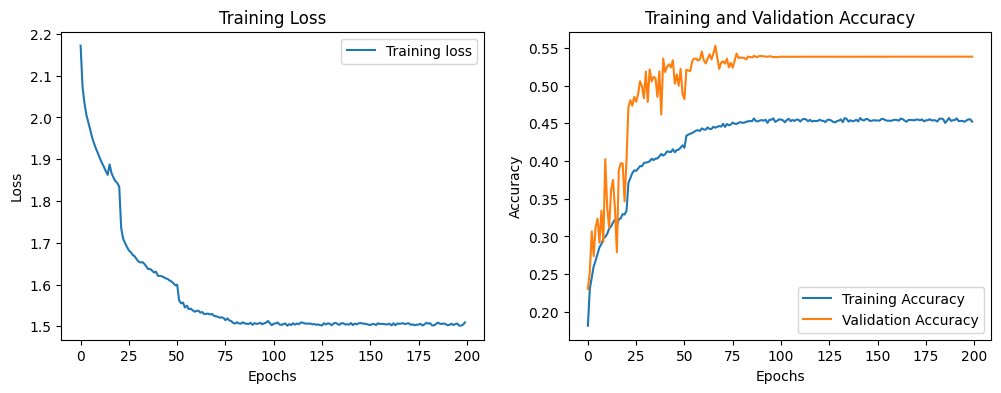

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from torchvision.transforms import Lambda
import matplotlib.pyplot as plt

# Define AlexNet adapted for CIFAR-10/CIFAR-100
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.avg_pooling = torch.nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# PCA Color Augmentation
def pca_color_augmentation(image):
    reshaped_image = image.reshape(-1, 3).astype(np.float32)
    mean = np.mean(reshaped_image, axis=0)
    std = np.std(reshaped_image, axis=0)

    # Avoid division by zero
    std[std == 0] = 1

    normalized_image = (reshaped_image - mean) / std

    cov_matrix = np.cov(normalized_image, rowvar=False)

    # Add a small value to the diagonal for numerical stability
    cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-5

    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]
    eigenvalues = eigenvalues[sorted_indices]

    alphas = np.random.normal(0, 0.1, 3)
    pca_jitter = np.dot(eigenvectors, alphas * eigenvalues)
    pca_jitter = (pca_jitter * std + mean).astype(np.float32)
    augmented_image = normalized_image + pca_jitter
    augmented_image = (augmented_image * std + mean).astype(np.uint8)

    return augmented_image.reshape(image.shape)

# Transforms including PCA color augmentation
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4), #40x40 pixels before the crop.
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    Lambda(lambda x: torch.tensor(pca_color_augmentation(x.numpy().transpose((1, 2, 0))), dtype=torch.float32).permute(2, 0, 1)),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 or CIFAR-100
def get_dataloaders(dataset='CIFAR10', batch_size=128):
    if dataset == 'CIFAR10':
        train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
        test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)
        num_classes = 10
    elif dataset == 'CIFAR100':
        train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transforms)
        test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transforms)
        num_classes = 100

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, test_loader, num_classes

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=25, device='cuda'):
    model.to(device)
    best_acc = 0.0

    # Lists for storing metrics
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)

        val_acc = val_running_corrects.double() / len(test_loader.dataset)
        val_accuracies.append(val_acc.item())

        print(f'Epoch {epoch}/{num_epochs-1}, Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}')

        # Step the scheduler
        scheduler.step(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)

    # Plotting training metrics
    epochs = range(num_epochs)
    plt.figure(figsize=(12, 4))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

    return model

# Define dataset and dataloaders
train_loader, test_loader, num_classes = get_dataloaders(dataset='CIFAR10', batch_size=128)

# Initialize model, loss function, optimizer, and scheduler
model = AlexNet(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10, verbose=True, eps=1e-8)

# Train the model
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=200)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [ ]:


class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),  # LRN layer
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),  # LRN layer
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # Typically, avgpooling is not used in the original AlexNet implementation
        # but added for flexibility with different input sizes
        self.avgpooling = nn.AdaptiveAvgPool2d((6, 6))  # Not originally in AlexNet

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpooling(x)  # If using adaptive average pooling
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Example instantiation
# model = AlexNet(num_classes=1000)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [ ]:

class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features_Extracter = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75),
            nn.MaxPool2d(kernel_size=3, stride=2),


            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75),
            nn.MaxPool2d(kernel_size=3, stride=2),


            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), ###image dim=6*6


        )
        self.avgpooling = torch.nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features_Extracter(x)
        x = self.avgpooling(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x






In [ ]:
def compute_pca_components(trainset):
    data = np.concatenate([np.asarray(trainset[i][0]) for i in range(len(trainset))], axis=2)
    data = data.reshape(-1, 3)  # Flatten the image pixels
    mean = np.mean(data, axis=0)
    data -= mean
    cov = np.cov(data, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov)
    return eigvals, eigvecs, mean

class PCATransform:
    def __init__(self, eigvals, eigvecs, mean, alpha_std=0.1):
        self.eigvals = eigvals
        self.eigvecs = eigvecs
        self.mean = mean
        self.alpha_std = alpha_std

    def __call__(self, img):
        img = np.asarray(img).astype('float32')
        img = img - self.mean
        alpha = np.random.normal(0, self.alpha_std, size=3)
        delta = np.dot(self.eigvecs, self.eigvals * alpha)
        img = img + delta
        img = img + self.mean
        img = np.clip(img, 0, 255)
        return torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)


In [ ]:
import numpy as np

In [ ]:
def get_dataloader(dataset='CIFAR10', batch_size=128, train=True, transform=None):
    if transform is None:
        if train:
            transform_list = [
                transforms.Resize(227),  # To ensure that it doesn't get smaller than 6x6
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        else:
            transform_list = [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        transform = transforms.Compose(transform_list)

    if dataset == 'CIFAR10':
        dataset_obj = datasets.CIFAR10(root='./data', train=train, download=True, transform=transform)
    elif dataset == 'CIFAR100':
        dataset_obj = datasets.CIFAR100(root='./data', train=train, download=True, transform=transform)
    else:
        raise ValueError('Dataset must be either CIFAR10 or CIFAR100')

    if train:
        eigvals, eigvecs, mean = compute_pca_components(dataset_obj)
        pca_transform = PCATransform(eigvals, eigvecs, mean)
        # Update the transform with PCA transform
        transform.transforms.insert(3, pca_transform)  # Insert PCA transform after horizontal flip

    dataloader = DataLoader(dataset_obj, batch_size=batch_size, shuffle=True, num_workers=2)
    return dataloader



In [ ]:
print("done?")

done?


In [ ]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0) #contribution for each single batch in the epoch

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(val_loader.dataset)
    accuracy = 100. * correct / total
    return epoch_loss, accuracy


In [ ]:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_classes = 10  # Change to 100 for CIFAR-100
    model = AlexNet(num_classes=num_classes).to(device)

    train_loader = get_dataloader(dataset='CIFAR10', batch_size=128, train=True)
    val_loader = get_dataloader(dataset='CIFAR10', batch_size=128, train=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

    num_epochs = 25
    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

if __name__ == '__main__':
    main()


100%|██████████| 170498071/170498071 [00:09<00:00, 17940861.33it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.10/site-packages/torchvision/datasets/cifar.py", line 118, in __getitem__
    img = self.transform(img)
  File "/opt/conda/lib/python3.10/site-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
  File "/opt/conda/lib/python3.10/site-packages/torchvision/transforms/transforms.py", line 137, in __call__
    return F.to_tensor(pic)
  File "/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py", line 140, in to_tensor
    raise TypeError(f"pic should be PIL Image or ndarray. Got {type(pic)}")
TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>
